In [96]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials,align_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
import logging
from scipy import fft,signal
import os
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score,StratifiedKFold
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from multiprocessing import Pool
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.structures.neuron_data import NeuronData
#from ephysvibe.structures.eye_data import EyeData
import pandas as pd
import platform
#from ephysvibe.structures.lfp_data import LfpData
from ephysvibe.spike_sorting import config
import h5py
import glob
from joblib import Parallel, delayed
from tqdm import tqdm

In [ ]:
def count_neu_position(count_matrix,matrix,info,area,idx_paths):
    for i_path in idx_paths:
        path=info[area]['paths'][i_path]
        neu_data = NeuronData.from_python_hdf5(path)
        row,col = np.where(neu_data.cluster_ch==matrix)
        count_matrix[row,col] +=1
        
    return {'count_matrix':count_matrix,'session':path.rsplit('/')[-1].rsplit('_Riesling')[0]}

In [ ]:
def get_avg_fr(sp):
    fr=np.nanmean(sp)*1000
    return fr

In [ ]:
def scale_p(x, out_range=(-1, 1)):
    if np.sum(x>1) >0:
        return
    domain = 0, 1
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [ ]:
def compute_roc_auc(group1,group2):
    roc_score = []
    p = []
    for n_win in np.arange(group1.shape[1]):
        g1 = group1[:,n_win]
        g2 = group2[:,n_win]
        p.append(stats.ttest_ind(g1, g2)[1])
        thresholds = np.unique(np.concatenate([g1,g2]))
        y_g1, y_g2 = np.ones(len(g1)),np.zeros(len(g2))
        score=0.5
        fpr,tpr=[],[]
        for threshold in thresholds:
            g1_y_pred,g2_y_pred = np.zeros(len(g1)),np.zeros(len(g2))
            g1_mask,g2_mask = g1>=threshold,g2>=threshold
            g1_y_pred[g1_mask],g2_y_pred[g2_mask] = 1,1
            tp = sum(np.logical_and(y_g1==1,g1_y_pred==1))
            fn = sum(np.logical_and(y_g1==1,g1_y_pred==0))
            tpr.append(tp/ (tp+fn) )
            fp = sum(np.logical_and(y_g2==0,g2_y_pred==1))
            tn = sum(np.logical_and(y_g2==0,g2_y_pred==0))
            fpr.append(fp/ (fp+tn) )
        if len(fpr) > 1:
            fpr,tpr=np.array(fpr),np.array(tpr)
            score = metrics.auc(fpr[fpr.argsort()],tpr[fpr.argsort()])
        roc_score.append(score)
    roc_score = np.array(roc_score)
    roc_score = scale_p(np.round(roc_score,2),out_range=[-1,1])
    return roc_score,p

In [ ]:
def find_significant(p_value:np.ndarray,win:int, step:int=1)-> np.ndarray:

    p_shape=p_value.shape
    sign = np.zeros((p_shape[0],int(np.floor(p_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,p_shape[1]-step,step):
        sign[:,count] = np.where(np.all(p_value[:,i_step:i_step+win]<0.05,axis=1),True,False)
        #sign[:,count] = np.where((np.sum(p_color_all[:,i_step:i_step+win]<0.01,axis=1)>=30),True,False)
        count +=1
    return sign

In [ ]:
def get_selectivity(sp_1,sp_2):
    roc_score,p_value = compute_roc_auc(sp_1,sp_2)
    win=50
    find_significant(p_value,win=50,step=1)

In [ ]:
#def extrac_neu_info(path):
neu_data = NeuronData.from_python_hdf5(path)
sp_in,mask_in = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block= 1,
    select_pos= 1,
    event ="sample_on",
    time_before = time_before,
    error_type= 0,
)
sp_out,mask_out = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block= 1,
    select_pos= -1,
    event ="sample_on",
    time_before = time_before,
    error_type= 0,
)


avgfr_in = get_avg_fr(sp_in)
avgfr_out = get_avg_fr(sp_out)
color_select = get_color_selectivity()
get_position_selectivity()
get_orientation_selectivity()
get_neutral_selectivity()

get_vd_index()


In [2]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [200]:
areas=['lip','v4','pfc']
info = {'lip':{},'v4':{},'pfc':{}}
for area in areas:
    neu_path = basepath+'session_struct/'+area+'/neurons/*neu.h5'
    path_list = glob.glob(neu_path)
    info[area]['paths']=path_list
    pp = []
    for path in path_list[:300]:
        pp.append(path.rsplit('/')[-1].rsplit('_Riesling')[0])
    info[area]['sessions']=np.unique(pp).tolist()

In [201]:
area_data = {}
for area in ['pfc']:
    matrix_bl = pd.read_csv('/home/INT/losada.c/Documents/codes/Users/losadac/data_stats/'+area+'_ch_pos.csv',header=0,index_col=0)
    matrix_df = matrix_bl#-matrix_bl.min().min()
    matrix = matrix_df.values
    count_matrix = np.zeros(matrix.shape)
    all_idx_session_paths=[]
    for i_sess in np.unique(info[area]['sessions']):
        all_idx_session_paths.append(np.where(np.char.find(info[area]['paths'], i_sess, start=0, end=None)!=-1)[0])
    data = Parallel(n_jobs = -1)(delayed(count_neu_position)(count_matrix,matrix,info,area,all_idx_session_paths[i]) for i in tqdm(range(len(all_idx_session_paths))))
    area_data[area]=data


100%|██████████| 7/7 [00:00<00:00, 7399.23it/s]


In [206]:
dd=NeuronData.from_python_hdf5( '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/pfc/neurons/2023-02-09_10-42-54_Riesling_pfc_e1_r1_mua7_neu.h5')
dd.cluster_array_pos

array(7)

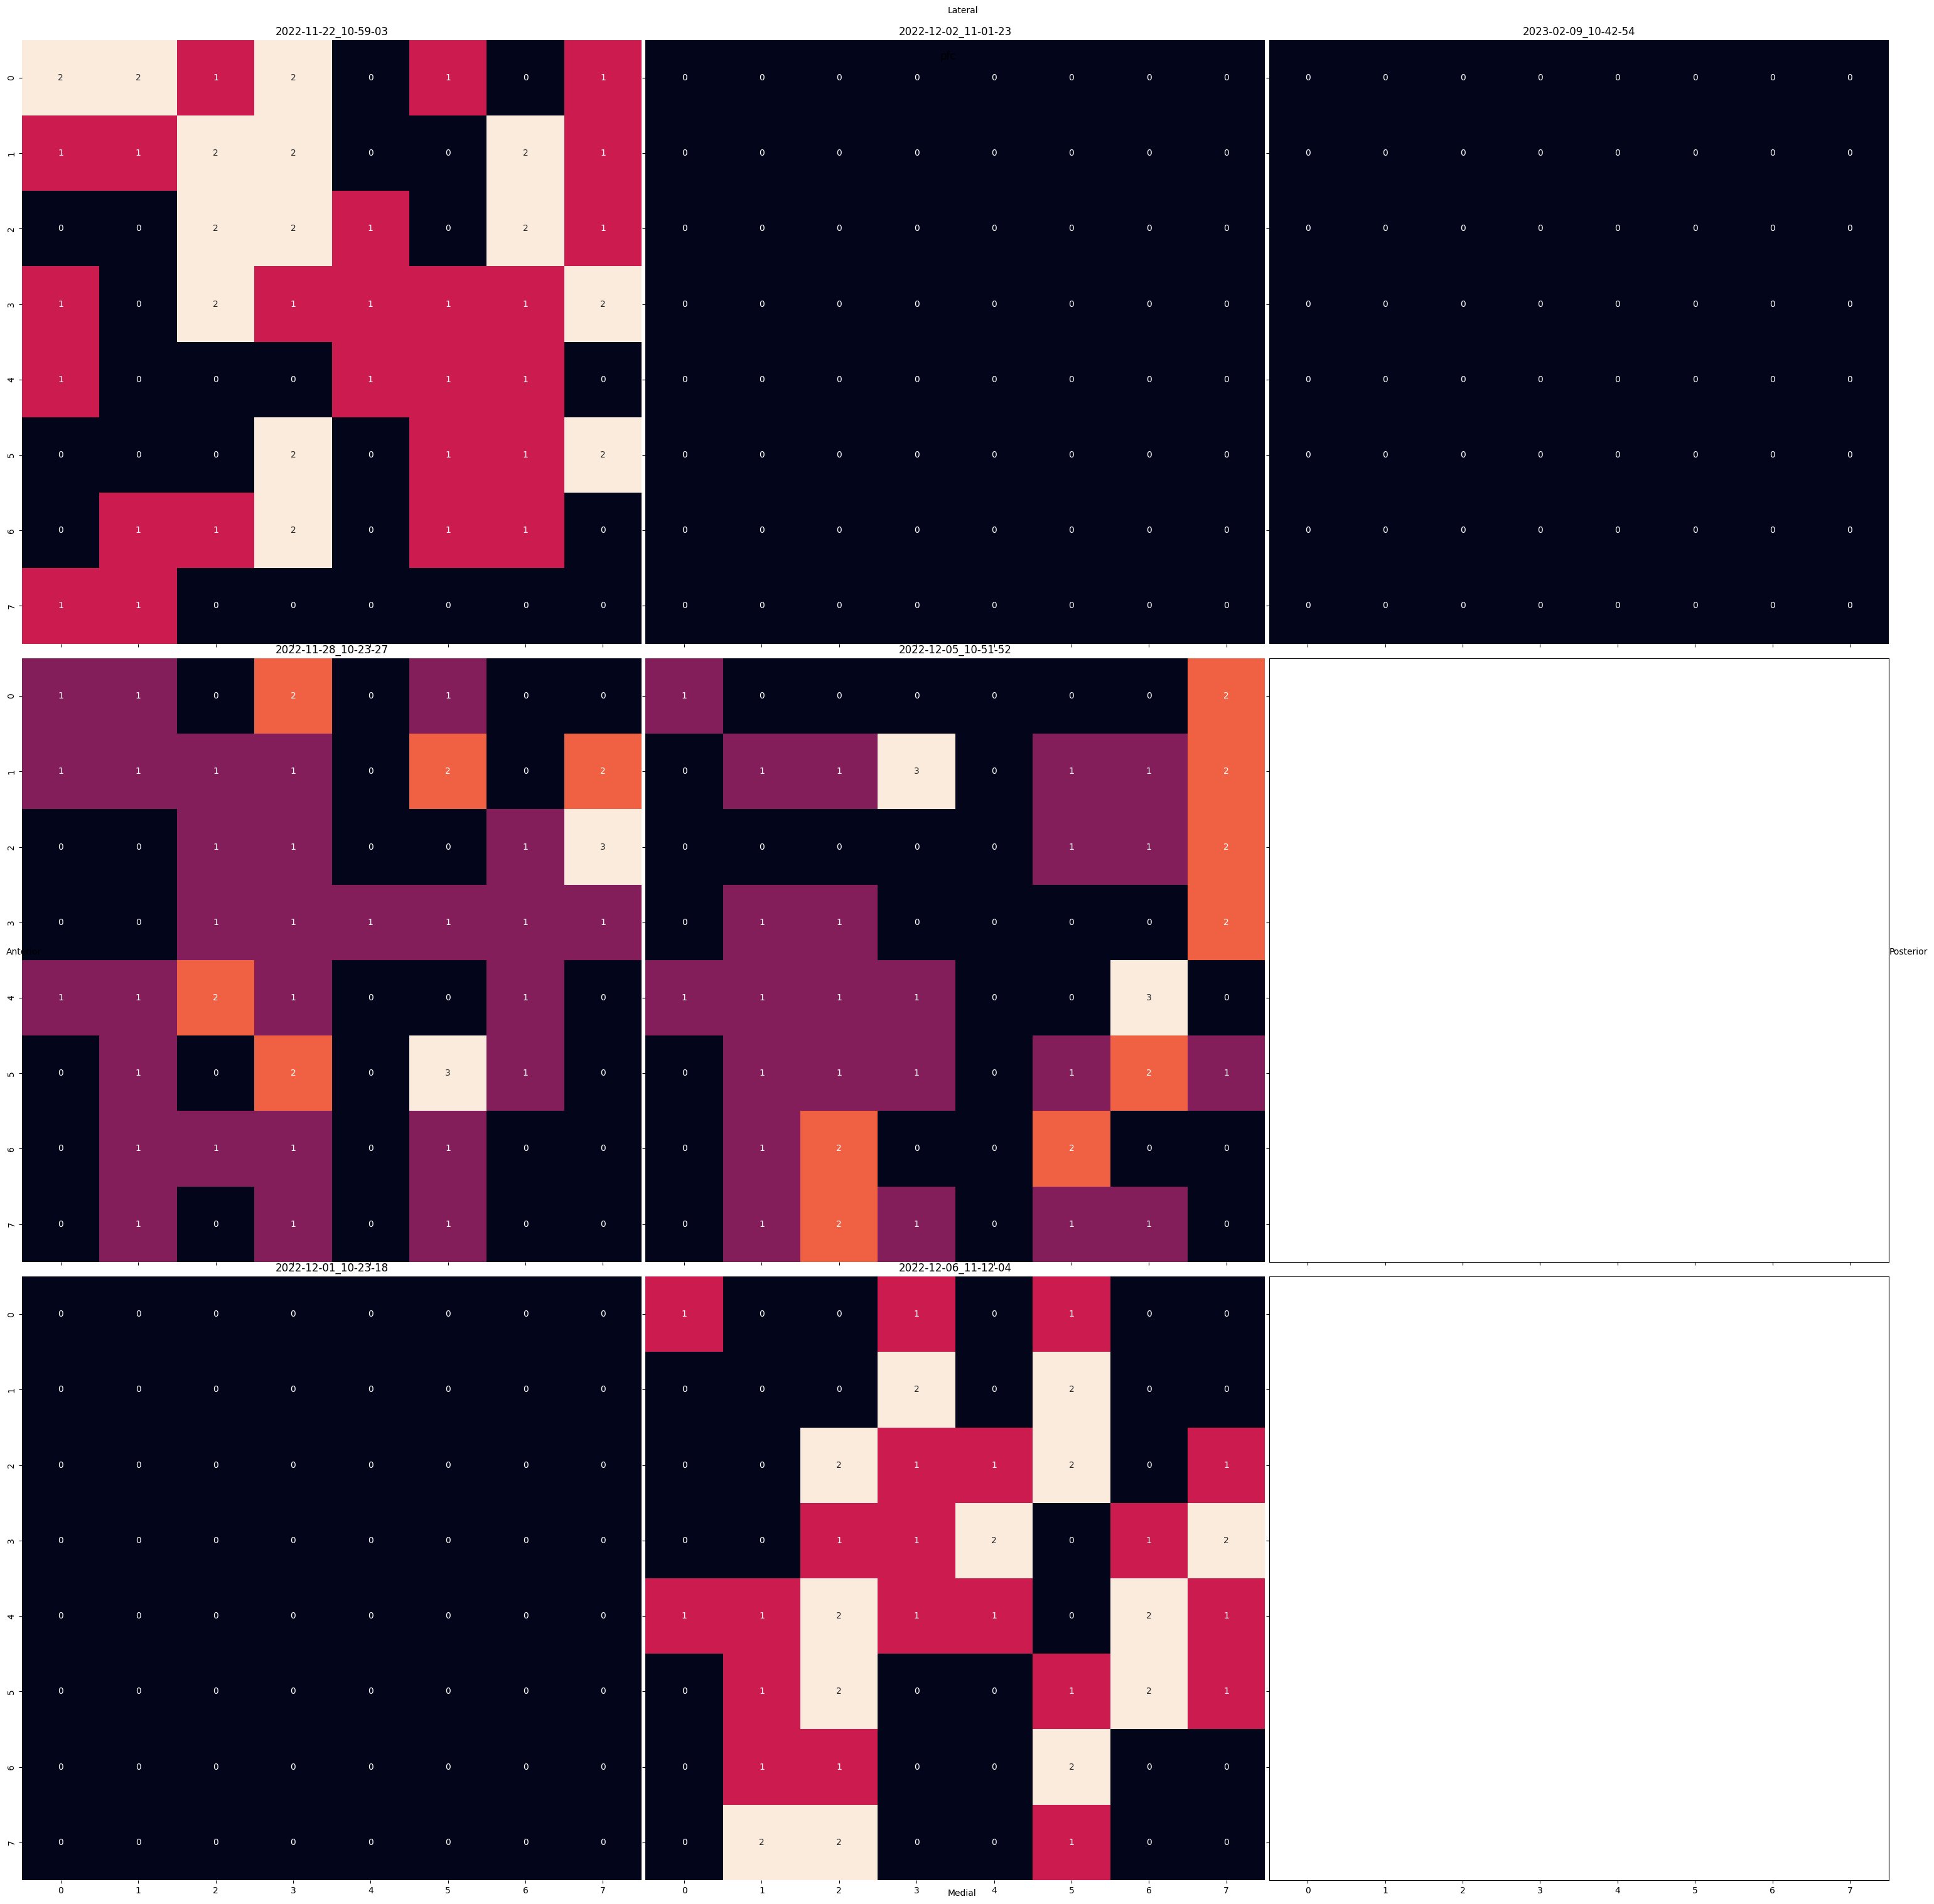

In [202]:
area = 'pfc'
data = area_data[area]
all_cmatrix = []
all_sess=[]
for asc in data:
    all_cmatrix.append(asc["count_matrix"])
    all_sess.append(asc["session"])
all_cmatrix=np.array(all_cmatrix)
all_sess=np.array(all_sess)

ncols = 3
nrows = int(np.ceil(all_cmatrix.shape[0]/ncols))
f,ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(30,30),sharex=True,sharey=True)
i_s = 0
for ic in range(ncols):
    for ir in range(nrows):
        sns.heatmap(all_cmatrix[i_s],annot=True,ax=ax[ir,ic],cbar=False)
        ax[ir,ic].set_title(all_sess[i_s])
        i_s+=1
        if i_s==len(all_cmatrix):
            break
f.suptitle(area)
f.text(0.5, 0, 'Medial'   )
f.text(0.5, 1, 'Lateral'  )
f.text(1, 0.5, 'Posterior')
f.text(0, 0.5, 'Anterior' )
f.tight_layout(pad=0.1, h_pad=0.1, w_pad=0.1)

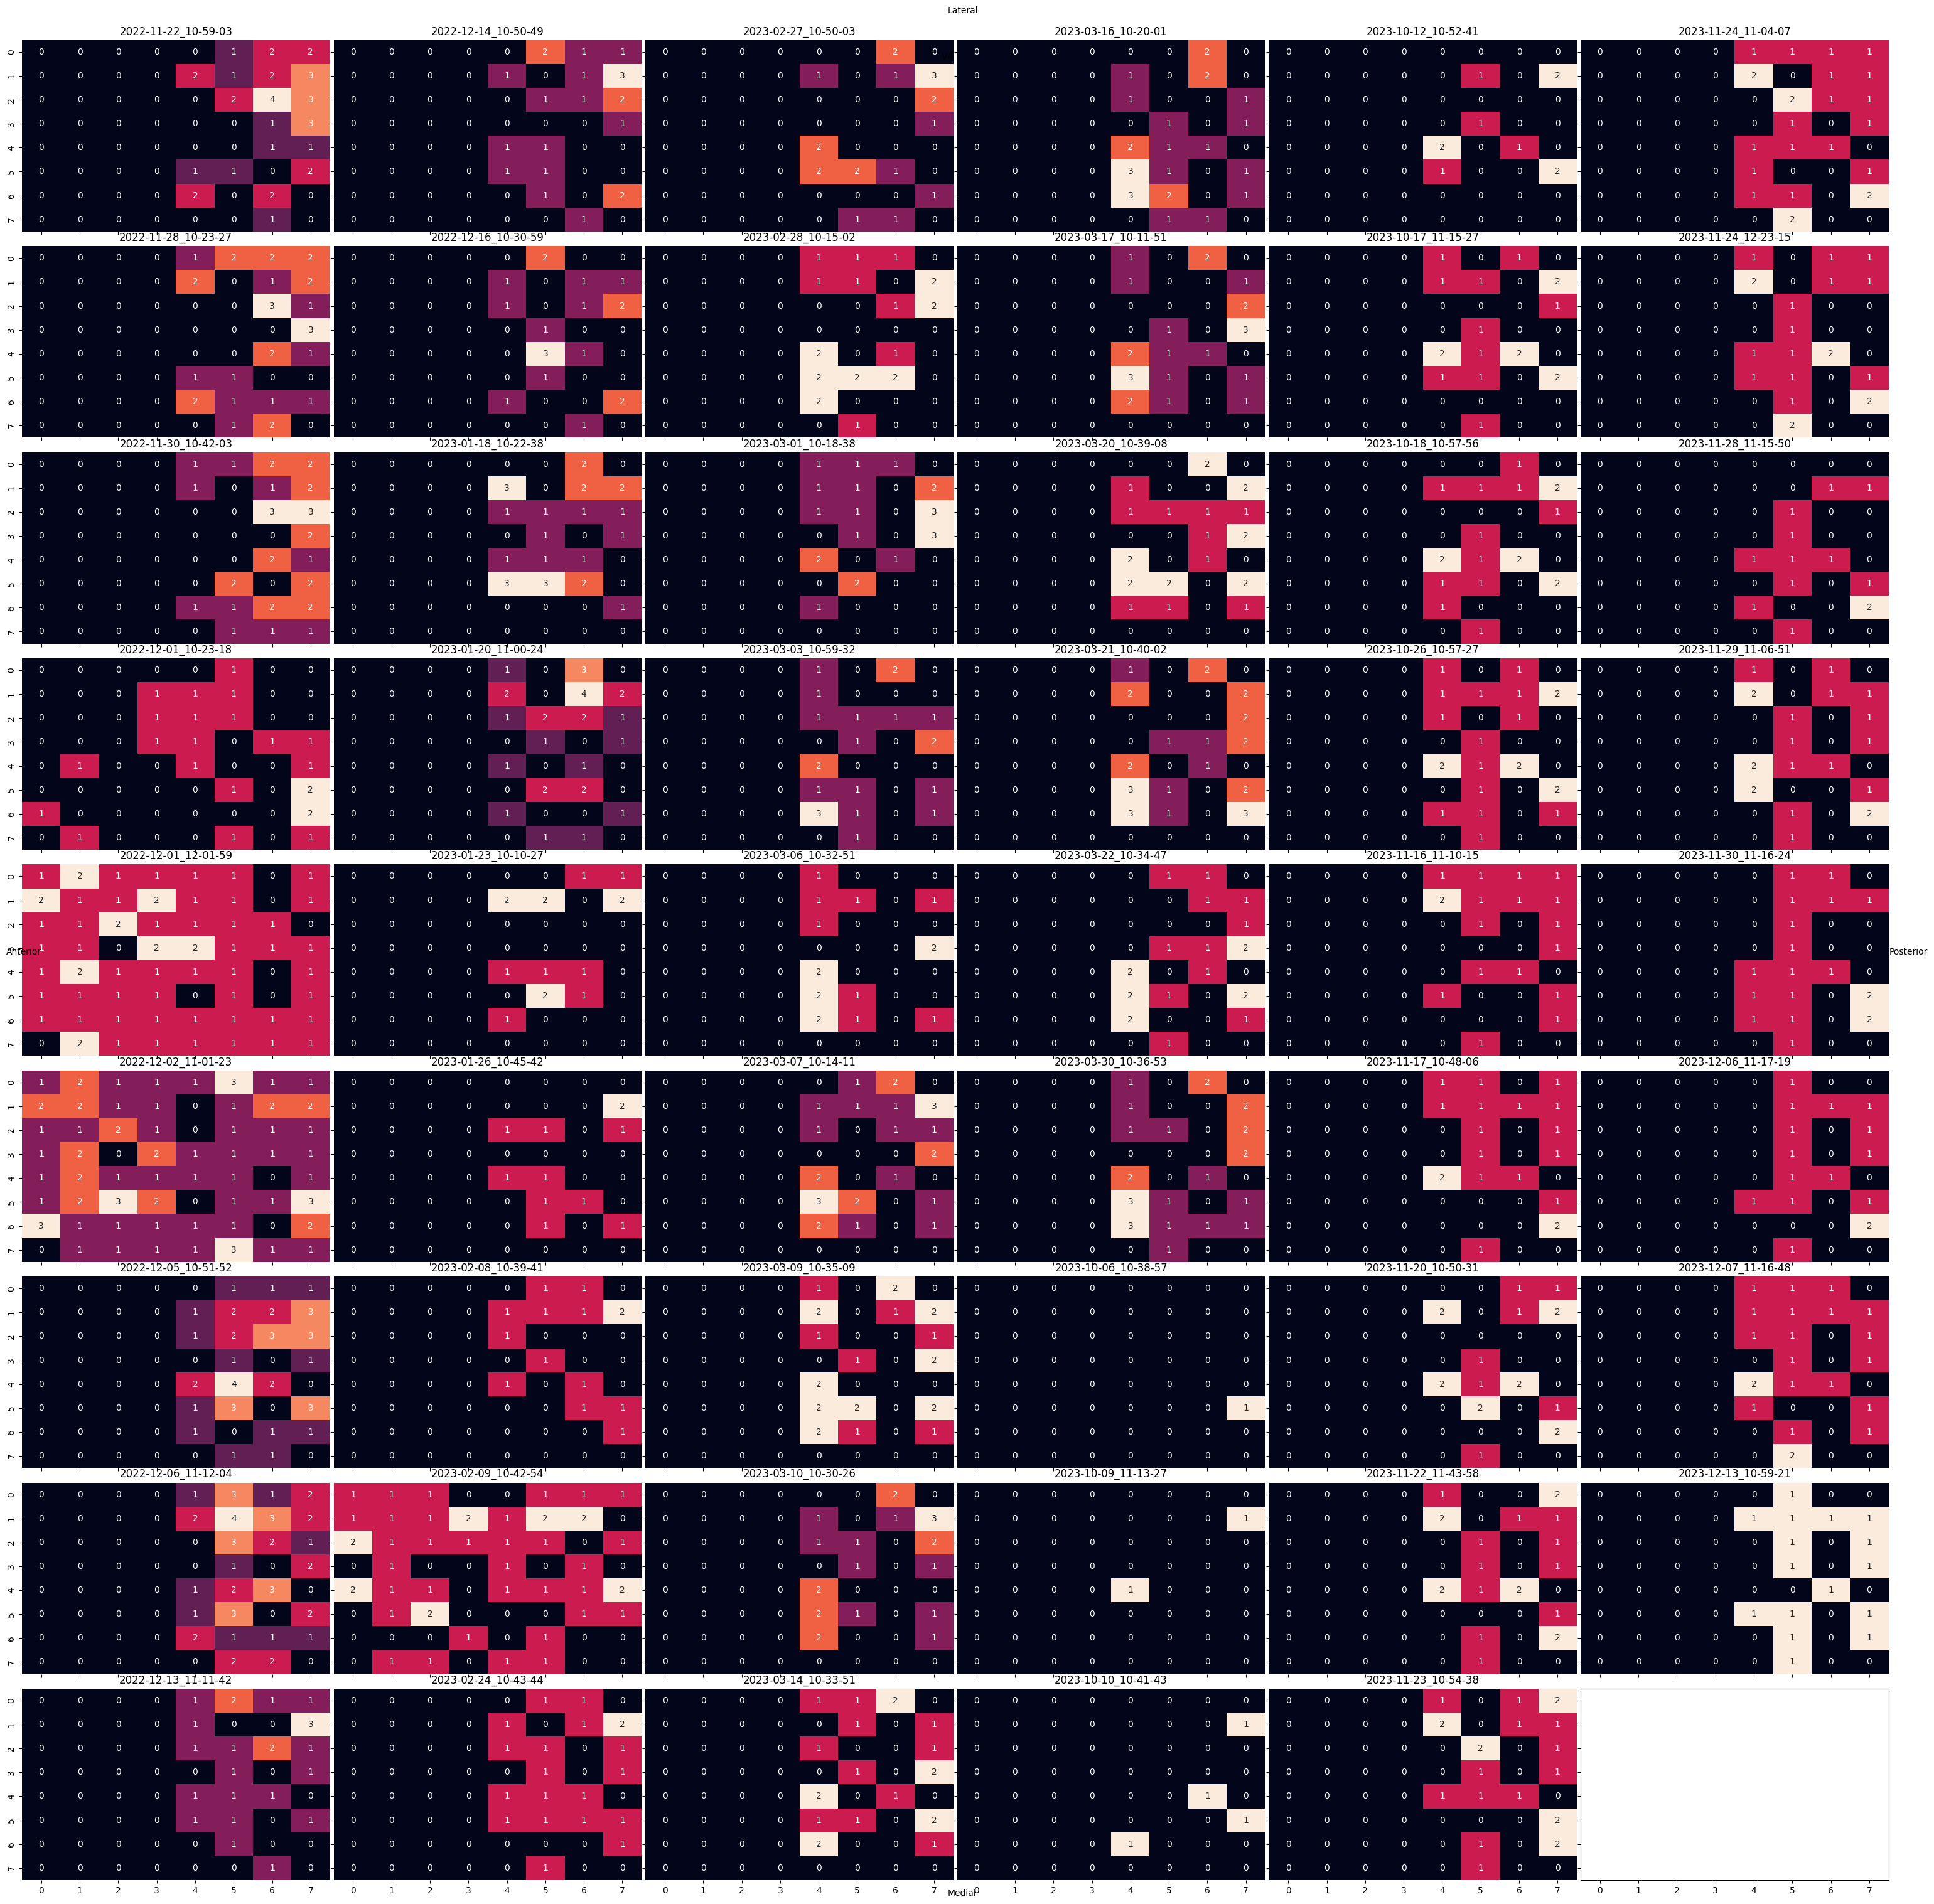

In [180]:
area = 'v4'
data = area_data[area]
all_cmatrix = []
all_sess=[]
for asc in data:
    all_cmatrix.append(asc["count_matrix"])
    all_sess.append(asc["session"])
all_cmatrix=np.array(all_cmatrix)
all_sess=np.array(all_sess)

ncols = 6
nrows = int(np.ceil(all_cmatrix.shape[0]/ncols))
f,ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(30,30),sharex=True,sharey=True)
i_s = 0
for ic in range(ncols):
    for ir in range(nrows):
        sns.heatmap(all_cmatrix[i_s],annot=True,ax=ax[ir,ic],cbar=False)
        ax[ir,ic].set_title(all_sess[i_s])
        i_s+=1
        if i_s==len(all_cmatrix):
            break
f.suptitle(area)
f.text(0.5, 0, 'Medial'   )
f.text(0.5, 1, 'Lateral'  )
f.text(1, 0.5, 'Posterior')
f.text(0, 0.5, 'Anterior' )
f.tight_layout(pad=0.1, h_pad=0.1, w_pad=0.1)